In [ ]:
# Notebook is strictly wip at this point, experimenting with the pmdarima pipeline.Pipeline

## FIND THE SOURCE FOR YEO_JOHNSON PLUG THAT IN HERE

In [53]:
#### SOURCE https://alkaline-ml.com/pmdarima/auto_examples/preprocessing/example_date_featurizer.html#sphx-glr-auto-examples-preprocessing-example-date-featurizer-py

import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima.arima import ADFTest 


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer


import cabi.etl.load as l
import cabi.etl.transform as t

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)



pmdarima version: 1.7.1


In [13]:
col = '2F'

In [14]:
series = l.load_counts(col)

In [27]:
series_four = t.cumulative_change(series, '6H')

In [28]:
fourhourly = t.series_to_interval(series, '1H')

In [29]:
fourhourly = fourhourly[(fourhourly.index >= '2020-06-15') & (fourhourly.index < '2020-08-01')]

In [18]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [35]:
series.head(50)

time
2020-04-01 00:25:48    0
2020-04-01 00:27:59    0
2020-04-01 01:36:09   -1
2020-04-01 01:39:17    1
2020-04-01 01:47:36    0
2020-04-01 01:59:15    0
2020-04-01 02:09:11    0
2020-04-01 02:49:12    0
2020-04-01 03:13:20    0
2020-04-01 03:15:58    0
2020-04-01 03:27:00    0
2020-04-01 03:47:29    0
2020-04-01 04:23:18    0
2020-04-01 04:36:09    0
2020-04-01 04:38:00   -1
2020-04-01 04:42:18    0
2020-04-01 04:48:14    0
2020-04-01 04:48:27   -1
2020-04-01 04:53:34    0
2020-04-01 04:54:08    0
2020-04-01 04:56:58    0
2020-04-01 05:03:39    1
2020-04-01 05:06:55    0
2020-04-01 05:18:20    0
2020-04-01 05:26:56   -1
2020-04-01 05:28:27    0
2020-04-01 05:29:01    0
2020-04-01 05:34:03    0
2020-04-01 05:34:38    0
2020-04-01 05:37:04    0
2020-04-01 05:37:04    0
2020-04-01 05:38:24    1
2020-04-01 05:40:17    0
2020-04-01 05:52:59    0
2020-04-01 05:55:29    0
2020-04-01 05:56:44    0
2020-04-01 05:59:34    0
2020-04-01 06:02:15    0
2020-04-01 06:05:52   -1
2020-04-01 06:06:48 

In [25]:
counts = l.load_counts_full()

In [146]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 1A/1C has most outflow, 2E/2B/6D have most inflow on average
counts.mean().sort_values()

1A   -0.00436
1C   -0.00305
3C   -0.00168
5E   -0.00108
4C   -0.00073
3E   -0.00072
1D   -0.00063
3B   -0.00051
3F   -0.00045
4D   -0.00024
6B   -0.00021
4B   -0.00013
3D   -0.00012
7B   -0.00011
8E   -0.00010
5B   -0.00010
4A   -0.00010
5A   -0.00008
1B   -0.00008
3G   -0.00005
8B   -0.00005
6A   -0.00003
5C   -0.00002
7E   -0.00002
8C   -0.00002
7C    0.00000
2D    0.00001
7F    0.00003
8D    0.00006
7D    0.00008
5D    0.00010
8A    0.00018
6E    0.00051
2A    0.00055
2F    0.00086
6C    0.00144
2C    0.00197
6D    0.00325
2E    0.00334
2B    0.00340
dtype: float64

In [151]:
bot_five = counts.sum().sort_values().head(5).index
top_five = counts.sum().sort_values().tail(5).index
print(top_five, bot_five)

Index(['6C', '2C', '6D', '2E', '2B'], dtype='object') Index(['1A', '1C', '3C', '5E', '4C'], dtype='object')


In [152]:
model_groups = list(bot_five) + list(top_five)

In [153]:
model_groups

['1A', '1C', '3C', '5E', '4C', '6C', '2C', '6D', '2E', '2B']

In [154]:
ser1A = counts['1A']

In [160]:
ser1A.rolling('1H').sum().max()

43.0

In [170]:
hourly_groups = counts[model_groups].resample('1H').sum()

In [177]:
hourly_groups = hourly_groups[hourly_groups.index > '2020-06-15']
hourly_groups

,1A,1C,3C,5E,4C,6C,2C,6D,2E,2B
time,,,,,,,,,,
2020-06-15 01:00:00,0,1,0,0,1,0,-1,2,0,2
2020-06-15 02:00:00,-1,0,0,0,0,0,1,0,1,0
2020-06-15 03:00:00,0,0,0,0,-1,0,0,0,1,-1
2020-06-15 04:00:00,-1,0,-1,0,0,-1,1,2,0,1
2020-06-15 05:00:00,-2,-2,-1,1,-2,2,0,2,2,-3
...,...,...,...,...,...,...,...,...,...,...
2020-08-01 04:00:00,0,0,0,0,0,0,0,0,0,0
2020-08-01 05:00:00,0,0,0,0,0,0,0,0,0,0
2020-08-01 06:00:00,0,0,0,0,0,0,0,0,0,0


In [183]:
# Observations, hourly groups are generally least active in either direction
# on or around 2AM, could be good col to drop
# negative trend is more pronounced on an hourly basis
for col in model_groups:
    print(hourly_groups[col].groupby(hourly_groups.index.hour).mean())


time
0     1.87234
1     0.45833
2    -0.18750
3     0.06250
4    -0.35417
5    -1.16667
6    -5.04167
7    -6.27083
8    -8.02083
9    -6.53191
10   -6.34043
11   -6.29787
12   -5.59574
13   -4.78723
14   -5.68085
15   -7.53191
16   -4.42553
17   -5.68085
18   -7.25532
19   -1.93617
20    1.65957
21    2.44681
22    2.72340
23    3.34043
Name: 1A, dtype: float64
time
0    -0.06383
1     0.70833
2     0.00000
3     0.00000
4    -0.08333
5    -0.89583
6    -2.60417
7    -3.52083
8    -6.64583
9    -6.31915
10   -6.00000
11   -4.31915
12   -4.70213
13   -3.29787
14   -4.48936
15   -3.06383
16   -3.63830
17   -1.04255
18   -2.14894
19   -0.72340
20    1.42553
21    0.70213
22    0.76596
23   -0.31915
Name: 1C, dtype: float64
time
0     0.19149
1     0.16667
2     0.06250
3     0.00000
4    -0.10417
5    -0.81250
6    -0.83333
7    -2.58333
8    -1.97917
9    -2.04255
10   -2.61702
11   -2.21277
12   -2.00000
13   -0.65957
14   -1.27660
15   -1.02128
16   -1.31915
17   -1.23404
18   -1.531

<AxesSubplot:>

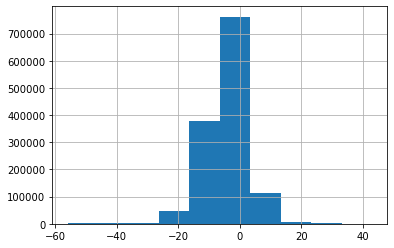

In [162]:
# The series has a tendency towards outflow
ser1A.rolling('1H').sum().hist()

In [198]:
from pmdarima.preprocessing import DateFeaturizer

# create time column
time_vals = hourly_groups.index.values
hourly_groups['time'] = time_vals

In [199]:
hourly_groups

,1A,1C,3C,5E,4C,6C,2C,6D,2E,2B,time
time,,,,,,,,,,,
2020-06-15 01:00:00,0,1,0,0,1,0,-1,2,0,2,2020-06-15 01:00:00
2020-06-15 02:00:00,-1,0,0,0,0,0,1,0,1,0,2020-06-15 02:00:00
2020-06-15 03:00:00,0,0,0,0,-1,0,0,0,1,-1,2020-06-15 03:00:00
2020-06-15 04:00:00,-1,0,-1,0,0,-1,1,2,0,1,2020-06-15 04:00:00
2020-06-15 05:00:00,-2,-2,-1,1,-2,2,0,2,2,-3,2020-06-15 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 04:00:00,0,0,0,0,0,0,0,0,0,0,2020-08-01 04:00:00
2020-08-01 05:00:00,0,0,0,0,0,0,0,0,0,0,2020-08-01 05:00:00
2020-08-01 06:00:00,0,0,0,0,0,0,0,0,0,0,2020-08-01 06:00:00


In [200]:
wday_dums = DateFeaturizer(column_name='time', with_day_of_month=False)
_, day_dums = wday_dums.fit_transform(hourly_groups['1A'], hourly_groups)
day_dums

,1A,1C,3C,5E,4C,6C,2C,6D,2E,2B,DATE-WEEKDAY-0,DATE-WEEKDAY-1,DATE-WEEKDAY-2,DATE-WEEKDAY-3,DATE-WEEKDAY-4,DATE-WEEKDAY-5,DATE-WEEKDAY-6
0,0,1,0,0,1,0,-1,2,0,2,1,0,0,0,0,0,0
1,-1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,-1,0,0,0,1,-1,1,0,0,0,0,0,0
3,-1,0,-1,0,0,-1,1,2,0,1,1,0,0,0,0,0,0
4,-2,-2,-1,1,-2,2,0,2,2,-3,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [202]:
day_dums.drop('DATE-WEEKDAY-2', axis=1, inplace=True)

In [205]:
day_dums = day_dums[day_dums.columns[-6:]]

In [209]:
day_dums.set_index(hourly_groups.index, inplace=True)

In [210]:
day_dums.merge(hourly_dummies)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [167]:
from statsmodels.tsa.deterministic import CalendarSeasonality


In [180]:
hourly_dumgen = CalendarSeasonality('H', 'D')
hourly_dummies = daily_dummies.in_sample(hourly_groups.index)

In [181]:
hourly_dummies

,"s(H=1, period=D)","s(H=2, period=D)","s(H=3, period=D)","s(H=4, period=D)","s(H=5, period=D)","s(H=6, period=D)","s(H=7, period=D)","s(H=8, period=D)","s(H=9, period=D)","s(H=10, period=D)",...,"s(H=15, period=D)","s(H=16, period=D)","s(H=17, period=D)","s(H=18, period=D)","s(H=19, period=D)","s(H=20, period=D)","s(H=21, period=D)","s(H=22, period=D)","s(H=23, period=D)","s(H=24, period=D)"
time,,,,,,,,,,,,,,,,,,,,,
2020-06-15 01:00:00,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-06-15 02:00:00,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-06-15 03:00:00,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-06-15 04:00:00,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-06-15 05:00:00,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 04:00:00,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-08-01 05:00:00,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2020-08-01 06:00:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [41]:
cum2F = t.cumulative_change(counts['2F'], '6H')

<AxesSubplot:xlabel='time'>

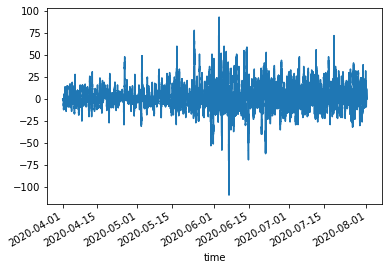

In [42]:
cum2F.plot()

In [43]:
cum2Fint = t.series_to_interval(cum2F, '1H')

In [50]:
# series = cum2Fint[(cum2F.index >= '2020-06-15') & (cum2F.index < '2020-08-01')]
series = cum2Fint[cum2Fint.index > '2020-06-15']

<AxesSubplot:xlabel='time'>

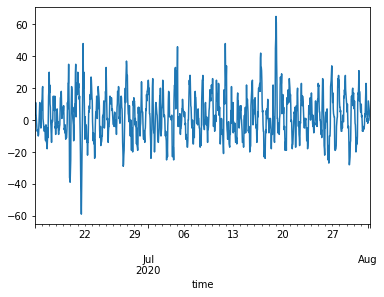

In [51]:
series.plot()

In [59]:
# Stationary

In [58]:
ADFTest(.05).should_diff(series)

(0.01, False)

In [ ]:
%%time

# Load the data and split it into separate pieces
y, X = hourly['2F'], hourly[['time']]
y_train, y_test, X_train, X_test = \
    model_selection.train_test_split(y, X, test_size=48)

# We can examine traits about the time series:
pm.tsdisplay(y_train, lag_max=10)

# We can see the ACF increases and decreases rather rapidly, which means we may
# need some differencing. There also does not appear to be an obvious seasonal
# trend.
n_diffs = arima.ndiffs(y_train, max_d=5)

# Here's what the featurizer will create for us:
date_feat = preprocessing.DateFeaturizer(
    column_name="time",  # the name of the date feature in the exog matrix
    with_day_of_week=True,
    with_day_of_month=False)



_, X_train_feats = date_feat.fit_transform(y_train, X_train)
print("Head of generated exog features:\n%s" % repr(X_train_feats.head()))

# We can plug this exog featurizer into a pipeline:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=True,
                              m=24
                             ))
])

pipe.fit(y_train, X_train)

# Plot our forecasts
forecasts = pipe.predict(exogenous=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
ax.set_title('Predicted Foo')
ax.set_ylabel('# Foo')

plt.show()

print(RMSE(y_test, forecasts))

# What next? Try combining different featurizers in your pipeline to enhance
# a model's predictive power.

## Cross Validation

In [60]:
series

time
2020-06-15 01:00:00     3.0
2020-06-15 02:00:00    11.0
2020-06-15 03:00:00     4.0
2020-06-15 04:00:00     2.0
2020-06-15 05:00:00    -1.0
                       ... 
2020-08-01 04:00:00     8.0
2020-08-01 05:00:00     6.0
2020-08-01 06:00:00     4.0
2020-08-01 07:00:00     2.0
2020-08-01 08:00:00     0.0
Freq: H, Name: 2F, Length: 1136, dtype: float64

In [62]:
%%time



# Load the data and split it into separate pieces #
train, test = model_selection.train_test_split(series, train_size=672)

#Validate 72 hour forecast over 1 week windows 6 days apart 
cv = model_selection.SlidingWindowForecastCV(window_size=168, step=144, h=72)




# value of lambda2 to ensure all values are positive for boxcox
lam2 = np.abs(series.min()) + 1e-6

# first fit our model to validate with pipeline
pipe = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              nfits=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe_cv_scores = model_selection.cross_val_score(
    pipe, train, scoring='smape', cv=cv, verbose=2)

print("Pipe CV scores: {}".format(pipe_cv_scores.tolist()))

# Pick based on which has a lower mean error rate
pipe_average_error = np.average(pipe_cv_scores)

print(pipe)
print(pipe_average_error)





[CV] fold=0 ..........................................................
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=1399.782, Time=6.39 sec
First viable model found (1399.782)
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=1387.250, Time=0.06 sec
New best model found (1387.250 < 1399.782)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1388.979, Time=2.78 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=1397.713, Time=1.80 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=1385.296, Time=0.34 sec
New best model found (1385.296 < 1387.250)
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=1387.060, Time=1.15 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=1387.068, Time=2.89 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=1384.473, Time=1.44 sec
New best model found (1384.473 < 1385.296)
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=1383.277, Time=3.27 sec
New best model found (1383.277 < 1384.473)
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=1383.965, Time=5.96 sec
Near non

/opt/anaconda3/envs/cabi-env/lib/python3.8/site-packages/pmdarima/preprocessing/endog/boxcox.py:164: RuntimeWarning: invalid value encountered in power
  de_exp = numer ** (1. / lam1)  # de-exponentiate


 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=1238.558, Time=6.17 sec
First viable model found (1238.558)
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=1269.942, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1237.472, Time=3.42 sec
New best model found (1237.472 < 1238.558)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=1191.619, Time=2.91 sec
New best model found (1191.619 < 1237.472)
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=1268.041, Time=0.22 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=1191.320, Time=0.51 sec
New best model found (1191.320 < 1191.619)
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=1191.604, Time=5.28 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=1196.472, Time=4.77 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=1165.187, Time=0.85 sec
New best model found (1165.187 < 1191.320)
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=1166.608, Time=3.42 sec
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=1166.620, Time=3.41 sec
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=1168.262, Ti

In [68]:
dir(cv)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_get_param_names',
 '_get_tags',
 '_iter_train_test_indices',
 '_iter_train_test_masks',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'get_params',
 'h',
 'horizon',
 'set_params',
 'split',
 'step',
 'window_size']

In [67]:
pipe

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_check_n_periods',
 '_final_estimator',
 '_get_kwargs',
 '_get_param_names',
 '_get_tags',
 '_iter',
 '_more_tags',
 '_post_predict',
 '_pre_predict',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'fit',
 'get_params',
 'named_steps',
 'predict',
 'predict_in_sample',
 'set_params',
 'steps',
 'summary',
 'transform',
 'update']

In [74]:
new = series[series.index >= '2020-07-01']
new

time
2020-07-01 00:00:00    25.0
2020-07-01 01:00:00    22.0
2020-07-01 02:00:00    16.0
2020-07-01 03:00:00    20.0
2020-07-01 04:00:00     4.0
                       ... 
2020-08-01 04:00:00     8.0
2020-08-01 05:00:00     6.0
2020-08-01 06:00:00     4.0
2020-08-01 07:00:00     2.0
2020-08-01 08:00:00     0.0
Freq: H, Name: 2F, Length: 753, dtype: float64

In [75]:
%%capture fits --no-stderr

pipe_cv = model_selection.cross_validate(
    pipe, new, scoring='smape', cv=cv, verbose=2)

In [76]:
pipe_cv

{'test_score': array([122.70480762, 112.20384569,  75.10836827, 117.73658181]),
 'fit_time': array([375.76898313, 260.85043311, 370.26738405, 213.57912302]),
 'score_time': array([0.01490784, 0.01439571, 0.01202273, 0.01152802])}

In [80]:
fits.stdout

'[CV] fold=0 ..........................................................\nPerforming stepwise search to minimize aic\nNear non-invertible roots for order (2, 0, 2)(1, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)\n ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=6.14 sec\n ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=530.539, Time=0.06 sec\nFirst viable model found (530.539)\n ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=389.651, Time=1.10 sec\nNew best model found (389.651 < 530.539)\nNear non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)\n ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.04 sec\n ARIMA(0,0,0)(0,1,0)[24]             : AIC=528.543, Time=0.30 sec\n ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=421.473, Time=0.16 sec\n ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=381.821, Time=2.48 sec\nNew best model found (38

In [82]:
fits_text = fits.stdout

In [83]:
import re

In [140]:
def get_cv_params(std_text):
    """accepts stdout generated by cross-validate, returns the "Best Model" Objects
     for each validated fold as a list of lists of ints
     Example output for a cv with four folds and s=24 might be
     [[2, 0, 3, 2, 1, 0, 24],
     [2, 0, 1, 2, 1, 0, 24],
     [3, 0, 3, 0, 1, 1, 24],
     [1, 0, 0, 0, 1, 1, 24]]"""
    # build a match pattern that matches a string that looks like
    # this: 'Best model:  ARIMA(1,0,0)(0,1,1)[24]' from full contents of stdout
    # containing the ARIMA parameters from each fold in a cv search
    mod_pattern = re.compile(r'Best.*24]')
    
    # Match the pattern against stdout
    pat_list = (re.findall('Best.*24]', std_text))
    # Find all digits in each param in pat_list, save as list of params
    params = [re.findall('\d', pat_list[j]) for j, _ in enumerate(pat_list)]
    # this is a bit complicated: but does a fairly simple thing:
    # converts params from a list of lists filled with digits as individual strings of len 1
    # to a list of lists filled with digits as ints. since s=24 is specified in our AutoArima pipe
    # the last two digits are always 2 and 4, we fix this by converting them both to 24 and
    # removing the last digit, converting a list like ['2', '0', '3', '2', '1', '0', '2', '4']
    # to for example [2, 0, 3, 2, 1, 0, 24], which we can feed as SARIMA params
    params = [[int(param[p]) if (p < len(param) - 2) else 24 for p,_ in enumerate(param)][:-1] for param in params]
    return params

In [141]:
get_cv_params(fits_text)

[[2, 0, 3, 2, 1, 0, 24],
 [2, 0, 1, 2, 1, 0, 24],
 [3, 0, 3, 0, 1, 1, 24],
 [1, 0, 0, 0, 1, 1, 24]]

In [137]:
pat_list = (re.findall('Best.*24]', fits_text))
# params = 
params = [re.findall('\d', pat_list[j]) for j, _ in enumerate(pat_list)]
# for i, param in enumerate(params):
#     params[i] = [int(i) for i in param]
# [[int(i) for i in param] for param in params]

# params = 
params = [[int(param[p]) if (p < len(param) - 2) else 24 for p,_ in enumerate(param)][:-1] for param in params]

In [138]:
params

[[2, 0, 3, 2, 1, 0, 24],
 [2, 0, 1, 2, 1, 0, 24],
 [3, 0, 3, 0, 1, 1, 24],
 [1, 0, 0, 0, 1, 1, 24]]

In [105]:
re.findall('\d', pat_list[0])

['2', '0', '3', '2', '1', '0', '2', '4']

In [ ]:
# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))


# pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

## 

In [9]:
%%time


# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

lam2 = np.abs(hourly.min()) + 1e-6
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              nfits=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])})

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')



42.000001

RMSE: 8.446309415011395
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  672
Model:             SARIMAX(5, 0, 0)x(2, 1, 0, 24)   Log Likelihood                -612.710
Date:                            Sat, 05 Sep 2020   AIC                           1257.420
Time:                                    14:01:41   BIC                           1329.002
Sample:                                         0   HQIC                          1285.189
                                            - 672                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FOURIER_S12-0  1.293e+04   1.23e+05      0.106      0.916   -2.27e+05    2.53e+05
FO

Text(0.5, 1.0, 'Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

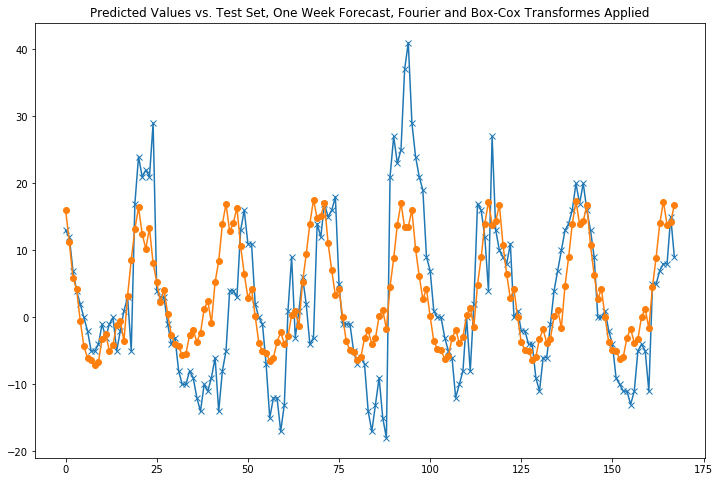

In [10]:
print(f'RMSE: {RMSE(test[:168],preds)}')

print(pipe.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

In [12]:
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')


RMSE 24 Hours: 5.277358272061359


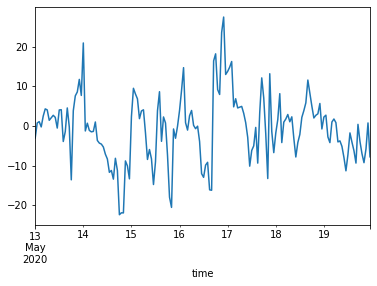

In [14]:
resid = test[:168] - preds
resid.plot()

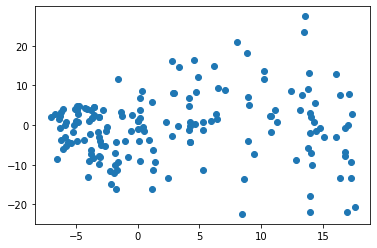

In [16]:
plt.scatter(x=preds, y=resid)

## Cross Validation Approach

### Because the Computation Time on these models is Extreme, We First Try SlidingWindowForecastCV

- If we are able to obtain good results this would be preferable method since it validates the same period length accross different windows in the data set

- The documentation states this well: "This approach to CV slides a window over the training samples while using several future samples as a test set. While similar to the RollingForecastCV, it differs in that the train set does not grow, but rather shifts." For those familiar with sklearn's TimeSeriesSplit, RollingWindowCV is essentially the same approach. Both TimeSeriesSplit and RollingWindowCV validate on a progressively larger portion of the data, with the test set being added to the next fold's trainset and the test window being shifted into the future accordingly.

- We validate in this manner on timeseries data, because the approach is dependent on the time-order of the observations, and so shuffling is not possible as it is under normal CV procedures.

In [17]:
from pmdarima.model_selection import RollingForecastCV

In [18]:
from pmdarima.metrics import smape

In [19]:
smape(test[:168][:24], preds[:24])

83.29270326557422

In [23]:
def SMAPE(y_true, y_pred):
    """Wrapper aroumd smape from pmdarima.metrics
    Returns value of smape on a 0-100% scale 
    instead of 0-200% for interpretability see
    https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    and https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.metrics.smape.html#pmdarima.metrics.smape
    for reference"""
    return smape(y_true, y_pred) / 2


In [21]:
pipe

Pipeline(steps=[('boxcox',
                 BoxCoxEndogTransformer(floor=1e-16, lmbda=None,
                                        lmbda2=42.000001, neg_action='raise')),
                ('fourier', FourierFeaturizer(k=4, m=12, prefix=None)),
                ('arima',
                 AutoARIMA(D=1, alpha=0.05, d=None, error_action='ignore',
                           information_criterion='aic', m=24, max_D=1, max_P=2,
                           max_Q=2, max_d=2, max_order=5, max_p=5, max_q=5,
                           maxiter=50, method='lbfgs', n_fits=10, n_jobs=1,
                           offset_test_args=None, out_of_sample_size=0,
                           random=False, random_state=None, scoring='mse',
                           scoring_args=None, seasonal=True,
                           seasonal_test='ocsb', seasonal_test_args=None,
                           start_P=1, start_Q=1, start_p=2, start_params=None, ...))])

In [22]:
%%time


# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(hourly, train_size=672)

lam2 = np.abs(hourly.min()) + 1e-6
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe2 = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer(lmbda2=lam2)),
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)), #attempt to capture 12 hour periods in the day
    ("arima", arima.AutoARIMA(stepwise=True, trace=3, error_action="ignore",
                              seasonal=True,
                              m=24,
                              D=1,
                              n_fits=4,
                              max_p=7,
                              max_P=3,
                              start_p=5,
                              start_P=2,
                              disp=True,
                              suppress_warnings=True))
])

pipe2.fit(train)
print("Model fit:")
print(pipe2)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe2.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')
print(f'SMAPE: {SMAPE(test[:168], preds)}')
print(f'SMAPE 24 hours: {SMAPE(test[:168][:24], preds[:24])}')
      

print(pipe2.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')



Performing stepwise search to minimize aic
Near non-invertible roots for order (5, 0, 2)(2, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(5,0,2)(2,1,1)[24] intercept   : AIC=inf, Time=64.88 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2273.845, Time=0.22 sec
First viable model found (2273.845)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1363.278, Time=4.86 sec
New best model found (1363.278 < 2273.845)
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=14.71 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2271.920, Time=0.86 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1546.218, Time=0.89 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1327.325, Time=12.18 sec
New best model found (1327.325 < 1363.278)
 ARIMA(1,0,0)(3,1,0)[24] intercept   : AIC=1266.582, Ti

NameError: name 'SMAPE' is not defined

Performing stepwise search to minimize aic
Near non-invertible roots for order (5, 0, 2)(2, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(5,0,2)(2,1,1)[24] intercept   : AIC=inf, Time=65.51 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=2273.845, Time=0.22 sec
First viable model found (2273.845)
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1363.278, Time=4.63 sec
New best model found (1363.278 < 2273.845)
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=15.15 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=2271.920, Time=0.90 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1546.218, Time=0.94 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=1327.325, Time=13.31 sec
New best model found (1327.325 < 1363.278)
 ARIMA(1,0,0)(3,1,0)[24] intercept   : AIC=1266.582, Ti

Text(0.5, 1.0, 'Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

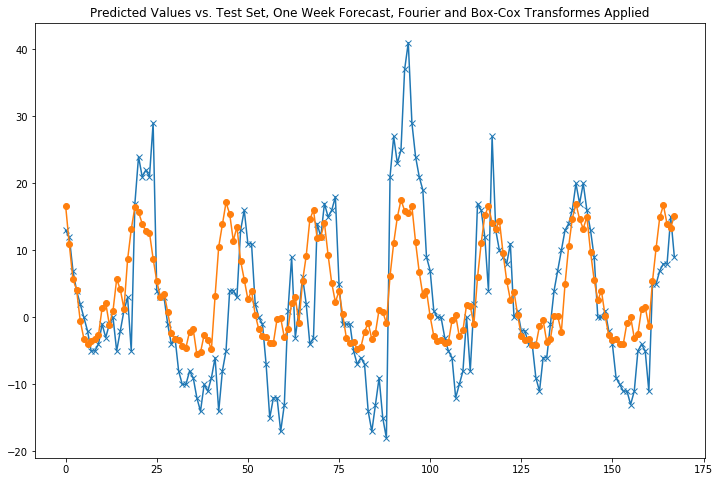

In [24]:
pipe2.fit(train)
print("Model fit:")
print(pipe2)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe2.predict(n_periods=168, return_conf_int=True)
print("\nForecasts:")
print(preds)

print(f'RMSE: {RMSE(test[:168],preds)}')
print(f'RMSE 24 Hours: {RMSE(test[:168][:24], preds[:24])}')
print(f'SMAPE: {SMAPE(test[:168], preds)}')
print(f'SMAPE 24 hours: {SMAPE(test[:168][:24], preds[:24])}')
      

print(pipe2.summary())

# pipe.plot_diagnostics()

fig, ax = plt.subplots(figsize=(12,8))

x = np.arange(test[:168].shape[0])
ax.plot(x, test[:168], marker='x')
ax.plot(x, preds, marker='o')
ax.set_title('Predicted Values vs. Test Set, One Week Forecast, Fourier and Box-Cox Transformes Applied')

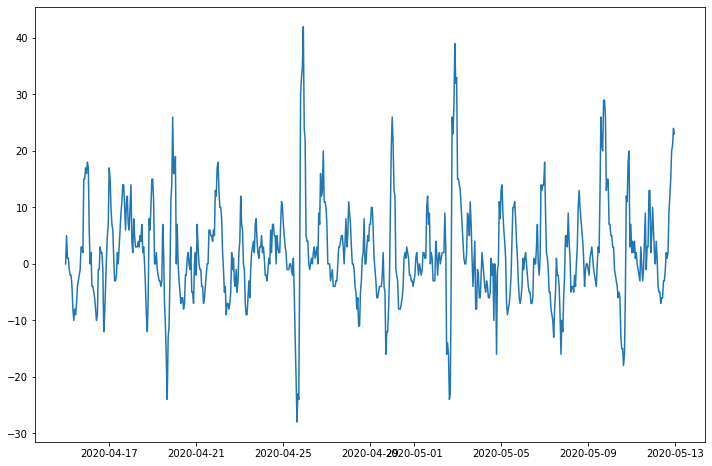

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train)